## Read data to to dataframe

In [50]:
import os
import pandas as pd
import skimage.io

In [59]:
DATASET_DIR = "TESS"
CSV_FILE_NAME = "metadata_transformed.csv"
FIG_SIZE = (6, 3)

# max frequency for spectrogram and mel_spectrogram
# MAX_FREQ = 8192

AUDIO_ID = 4

In [60]:
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
metadata_dir = os.path.join(project_dir, "metadata")

dataset_dir = os.path.join(metadata_dir, DATASET_DIR)

csv_file_path = os.path.join(dataset_dir, CSV_FILE_NAME)

In [61]:
df = pd.read_csv(csv_file_path)
df.head()

,name,extension,path,dirs
0,OAF_back_angry,wav,C:\users\user\studia\audio_clustering_autoenco...,OAF_angry
1,OAF_bar_angry,wav,C:\users\user\studia\audio_clustering_autoenco...,OAF_angry
2,OAF_base_angry,wav,C:\users\user\studia\audio_clustering_autoenco...,OAF_angry
3,OAF_bath_angry,wav,C:\users\user\studia\audio_clustering_autoenco...,OAF_angry
4,OAF_bean_angry,wav,C:\users\user\studia\audio_clustering_autoenco...,OAF_angry


## Retrieve features

In [62]:
import IPython.display as ipd
import librosa
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

In [63]:
# matplotlib.use('Agg')
print(f"Interactive mode: {matplotlib.is_interactive()}")
print(f"matplotlib backend: {matplotlib.rcParams['backend']}")

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

Interactive mode: True
matplotlib backend: module://matplotlib_inline.backend_inline


In [64]:
def get_audio(df, id):
    file_path = df.loc[id, 'path']
    return ipd.Audio(filename=file_path)


def display_audio(file):
    ipd.display(file)


def load_audio(df, id):
    file_path = df.loc[id, 'path']
#     sample_rate = librosa.get_samplerate(file_path)
    # decrease sample rate to 22KHz to simplify features
    sample_rate = 22050 
    return librosa.load(file_path, sr=sample_rate)


def load_audio_from_path(path):
    sample_rate = librosa.get_samplerate(path)
    # decrease sample rate to 22KHz to simplify features
    sample_rate = 22050 
    return librosa.load(path, sr=sample_rate)

In [65]:
audio = get_audio(df, AUDIO_ID)
display_audio(audio)

In [66]:
y, sr = load_audio(df, AUDIO_ID)
print(f"audio data (first 20): {y[:20]}")
print(f"audio data shape: {y.shape}")
print(f"sample rate: {sr}")

audio data (first 20): [-1.78125470e-06 -3.29618015e-05 -1.20288008e-04 -3.49853304e-04
 -5.39345434e-04 -5.02566574e-04 -2.90319702e-04 -1.17286865e-04
 -3.33961099e-04 -8.70797609e-04 -8.92797136e-04 -3.78994795e-04
 -1.73614069e-04 -2.53570644e-04 -4.18205047e-04 -5.04894764e-04
 -2.85748305e-04 -9.74749637e-05 -6.61731756e-05 -1.58262264e-04]
audio data shape: (30764,)
sample rate: 22050


In [67]:
def get_duration(y, sr):
    duration = "{:.3f}".format(librosa.get_duration(y=y, sr=sr))
    return duration


def get_tempo(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)
    tempo = "{:.3f}".format(tempo[0])
    return tempo


def get_mean_root_square_mean(y): 
    mean_root_square_mean = "{:.3f}".format(np.mean(librosa.feature.rms(y=y)))
    return mean_root_square_mean


def get_mean_zero_crossing_rate(y): 
    maen_zero_crossing_rate = "{:.3f}".format(np.mean(librosa.feature.zero_crossing_rate(y=y)))
    return maen_zero_crossing_rate


def get_mean_spectral_centroid(y): 
    maen_spectral_centroid = "{:.3f}".format(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    return maen_spectral_centroid


def get_mean_spectral_bandwith(y, sr): 
    maen_spectral_bandwith = "{:.3f}".format(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    return maen_spectral_bandwith


def get_mean_spectral_roll_off(y, sr): 
    maen_spectral_roll_off = "{:.3f}".format(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
    return maen_spectral_roll_off

In [68]:
# === SPECTROGRAM ===
def get_spectrogram(y):
    # hop_length = win_length / 2 = n_fft / 2 = 2048 / 2
    D = librosa.stft(y, hop_length=2048 // 2)
    dB_scaled_spectrogram = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return dB_scaled_spectrogram


def get_spectrogram_img(spectrogram, sr, ax, grayscale=True):
    cmap = 'gray' if grayscale else 'magma'
    
    return librosa.display.specshow(
        spectrogram,
        sr=sr,
        x_axis='time',
        y_axis='log',
        ax=ax,
        cmap=cmap
    )


def plot_spectrogram(spectrogram, sr, grayscale=True):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_spectrogram_img(spectrogram, sr, ax, grayscale)
    ax.set_title('Spectrogram', fontsize=20)
#     ax.set_ylim(0, MAX_FREQ)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    return fig

# === MEL spectrogram ===
def get_mel_spectrogram(y, sr):
    S = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=128, 
        hop_length=2048 // 2 
    )
    dB_scaled_spectrogram_mel = librosa.power_to_db(S, ref=np.max)
    return dB_scaled_spectrogram_mel


def get_mel_spectrogram_img(mel_spectrogram, sr, ax, grayscale=True):
    cmap = 'gray' if grayscale else 'magma'
    
    return librosa.display.specshow(
        mel_spectrogram,
        sr=sr,
        x_axis='time',
        y_axis='mel',
        ax=ax,
        cmap=cmap
    )

def plot_mel_spectrogram(mel_spectrogram, sr, grayscale=True):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_mel_spectrogram_img(mel_spectrogram, sr, ax, grayscale)
    ax.set_title('Mel Spectrogram', fontsize=20)
#     ax.set_ylim(0, MAX_FREQ)
    fig.colorbar(img, ax=ax, format='%0.2f')
    return fig


# === CHROMAGRAM ===
def get_chroma(y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return chroma


def get_chroma_img(chroma, sr, ax, grayscale=True):
    cmap = 'gray' if grayscale else 'magma'
    
    return librosa.display.specshow(
        chroma,
        sr=sr,
        y_axis='chroma', 
        x_axis='time',
        ax=ax,
        cmap=cmap
    )


def plot_chroma(chroma, sr, grayscale=True):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_chroma_img(chroma, sr, ax, grayscale)
    ax.set_title('Chromagram', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')

    return fig


def estimate_chroma_keys(chroma, n=3):
    mean_chroma = np.mean(chroma, axis=1)
    chroma_to_key = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    sorted_indices = np.argsort(mean_chroma)[::-1]
    top_n_indices = sorted_indices[:n]
    top_n_keys = [chroma_to_key[i] for i in top_n_indices]
    return top_n_keys
    
#     estimated_key_index = np.argmax(mean_chroma)
#     estimated_key = chroma_to_key[estimated_key_index]
#     return estimated_key


# === MFCCs ===
def get_mfccs(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    return mfccs


def get_mfccs_img(mfccs, sr, ax, grayscale=True):
    cmap = 'gray' if grayscale else 'magma'
    
    return librosa.display.specshow(
        mfccs,
        sr=sr,
        x_axis='time',
        ax=ax,
        cmap=cmap
    )


def plot_mfccs(mfccs, sr, grayscale=True):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_mfccs_img(mfccs, sr, ax, grayscale)
    ax.set_title('MFCCs', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.ylabel('MFCC Coefficients')

    return fig

In [69]:
# def scale_minmax(X, min=0.0, max=1.0):
#     X_std = (X - X.min()) / (X.max() - X.min())
#     X_scaled = X_std * (max - min) + min
#     return X_scaled


# def save_imagee(feature, output_file):
#     # min-max scale to fit inside 8-bit range
#     img = scale_minmax(feature, 0, 255).astype(np.uint8)
    
#     # put low frequencies at the bottom in image
#     img = np.flip(img, axis=0)
    
#     # invert, make black = more energy
#     img = 255 - img
    
#     skimage.io.imsave(output_file, img)
    

def save_image(fig, ax, output_file):
    ax.axis('off')
    fig.savefig(
        output_file, 
        bbox_inches='tight', 
        pad_inches=0,
        dpi=100
    )
    return f'{output_file}.png'

    
def save_spectrogram_image(spectrogram, sr, output_file):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_spectrogram_img(spectrogram, sr, ax)
    return save_image(fig, ax, output_file)


def save_mel_spectrogram_image(mel_spectrogram, sr, output_file):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_mel_spectrogram_img(mel_spectrogram, sr, ax)
    return save_image(fig, ax, output_file)

    
def save_chroma_image(chroma, sr, output_file):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_chroma_img(chroma, sr, ax)
    return save_image(fig, ax, output_file)

    
def save_mfccs_image(mfccs, sr, output_file):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    img = get_mfccs_img(mfccs, sr, ax)
    return save_image(fig, ax, output_file)
    
    
def save_numpy_array(array, output_file):
    np.save(output_file, array)
    return f'{output_file}.npy'

### Plot features

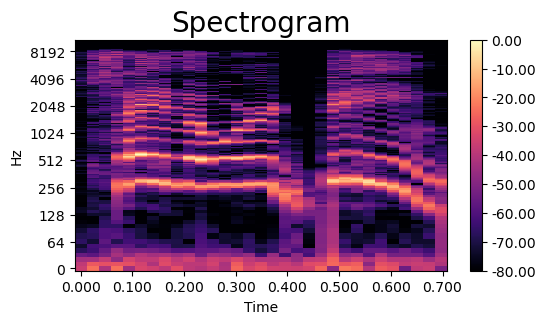

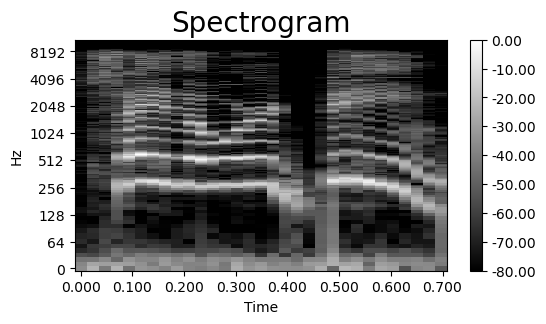

In [70]:
spectrogram = get_spectrogram(y)
figure = plot_spectrogram(spectrogram, sr, grayscale=False)
figure = plot_spectrogram(spectrogram, sr)
plt.show()

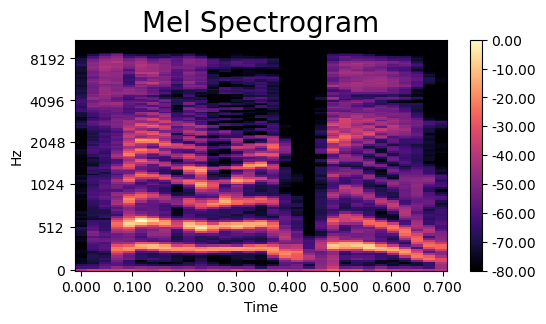

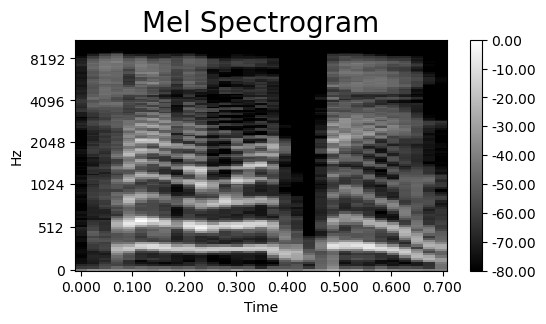

In [71]:
mel_spectrogram = get_mel_spectrogram(y, sr)
figure = plot_mel_spectrogram(mel_spectrogram, sr, grayscale=False)
figure = plot_mel_spectrogram(mel_spectrogram, sr)
plt.show()

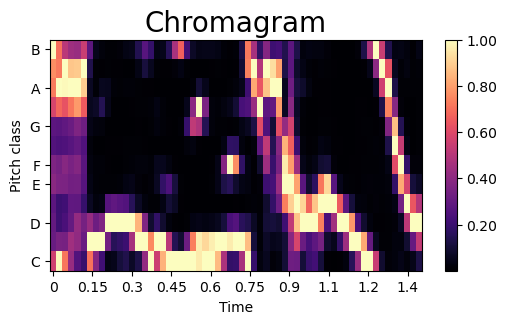

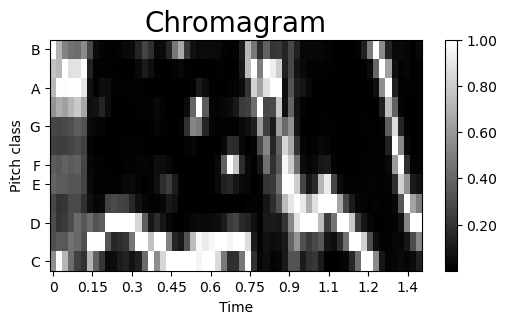

Estimated chroma keys: ['C#', 'C', 'D']


In [72]:
chroma = get_chroma(y, sr)
figure = plot_chroma(chroma, sr, grayscale=False)
figure = plot_chroma(chroma, sr)
plt.show()

top_3_chroma_keys = estimate_chroma_keys(chroma)
print(f'Estimated chroma keys: {top_3_chroma_keys}')

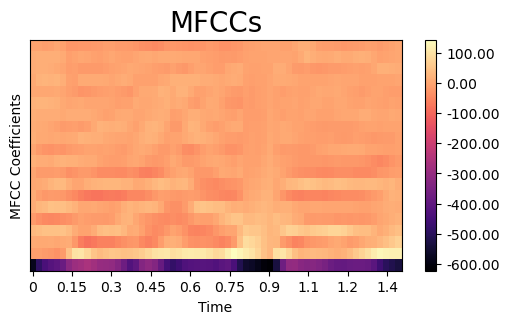

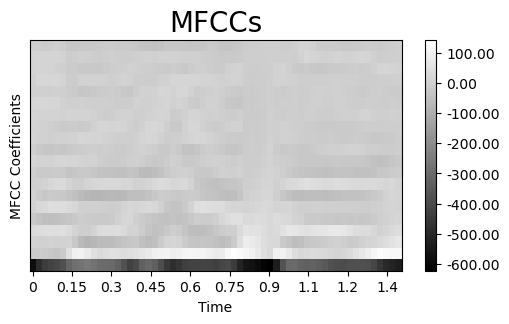

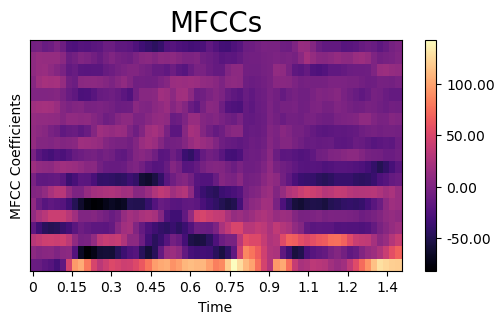

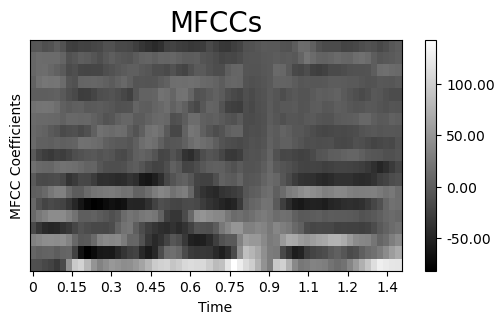

In [73]:
mfccs = get_mfccs(y, sr)
figure = plot_mfccs(mfccs, sr, grayscale=False)
figure = plot_mfccs(mfccs, sr)
plt.show()

# mfccs without first row
mfccs = np.delete(mfccs, 0, axis=0)
figure = plot_mfccs(mfccs, sr, grayscale=False)
figure = plot_mfccs(mfccs, sr)
plt.show()

In [74]:
import csv
import gc

In [75]:
project_dir = os.path.relpath(os.path.join(os.getcwd(), os.pardir))
features_dir = os.path.join(project_dir, "features")

dataset_dir = os.path.join(features_dir, DATASET_DIR)
os.makedirs(dataset_dir, exist_ok=True)

csv_file_name = "features.csv"
csv_file_path = os.path.join(dataset_dir, csv_file_name)


def get_output_file(parent_dirs, file_name, name):
    if parent_dirs != '':
        return f"{dataset_dir}\\{parent_dirs}\\{file_name}\\{name}"
    
    return f"{dataset_dir}\\{file_name}\\{name}"


def clear_fig_memory():
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()

In [76]:
num_rows = len(df)
data_list = [None] * num_rows

for index, row in df.iterrows():       
    name = row['name']
    path = row['path']    
    parent_dirs = row['dirs']

    y, sr = load_audio_from_path(path)

    output_file = get_output_file(parent_dirs, name, 'spectrogram')

    try:
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
    except Exception as e:
        print("Error creating directory:", e)

    # SPECTROGRAM
    spectrogram = get_spectrogram(y)
    path_spectrogram_img = save_spectrogram_image(spectrogram, sr, output_file)
    path_spectrogram_arr = save_numpy_array(spectrogram, output_file)
    clear_fig_memory()
    
    # MEL_SPECTROGRAM
    output_file = get_output_file(parent_dirs, name, 'mel_spectrogram')
    mel_spectrogram = get_mel_spectrogram(y, sr)
    path_mel_spectrogram_img = save_mel_spectrogram_image(mel_spectrogram, sr, output_file)
    path_mel_spectrogram_arr = save_numpy_array(mel_spectrogram, output_file)
    clear_fig_memory()
    
    # CHROMAGRAM
    output_file = get_output_file(parent_dirs, name, 'chromagram')
    chromagram = get_chroma(y, sr)
    
    top_3_chroma_keys = estimate_chroma_keys(chromagram)
    
    path_chromagram_img = save_chroma_image(chromagram, sr, output_file)
    path_chromagram_arr = save_numpy_array(chromagram, output_file)
    clear_fig_memory()
    
    # MFCCs
    output_file = get_output_file(parent_dirs, name, 'mfccs')
    mfccs = get_mfccs(y, sr)
    path_mfccs_img = save_mfccs_image(mfccs, sr, output_file)
    path_mfccs_arr = save_numpy_array(mfccs, output_file)
    clear_fig_memory()
    
    # MFCCs without first row
    output_file = get_output_file(parent_dirs, name, 'mfccs_without_0')
    mfccs = np.delete(mfccs, 0, axis=0)
    path_mfccs_without_0_img = save_mfccs_image(mfccs, sr, output_file)
    path_mfccs_without_0_arr = save_numpy_array(mfccs, output_file)
    clear_fig_memory()
    
    #TODO: change parent_dirs to actual label
    data_list[index] = {
        'name': name,
        'duration': get_duration(y, sr),
        'tempo': get_tempo(y, sr),
        'chroma_key_1': top_3_chroma_keys[0],
        'chroma_key_2': top_3_chroma_keys[1],
        'chroma_key_3': top_3_chroma_keys[2],
        'mean_root_square_mean': get_mean_root_square_mean(y),
        'mean_zero_crossing_rate': get_mean_zero_crossing_rate(y),
        'mean_spectral_centroid': get_mean_spectral_centroid(y),
        'mean_spectral_bandwith': get_mean_spectral_bandwith(y, sr),
        'mean_spectral_roll_off': get_mean_spectral_roll_off(y, sr),
        'path': path,
        'path_spectrogram_img': path_spectrogram_img,
        'path_spectrogram_arr': path_spectrogram_arr,
        'path_mel_spectrogram_img': path_mel_spectrogram_img,
        'path_mel_spectrogram_arr': path_mel_spectrogram_arr,
        'path_chromagram_img': path_chromagram_img,
        'path_chromagram_arr': path_chromagram_arr,
        'path_mfccs_img': path_mfccs_img,
        'path_mfccs_arr': path_mfccs_arr,
        'path_mfccs_without_0_img': path_mfccs_without_0_img,
        'path_mfccs_without_0_arr': path_mfccs_without_0_arr,
        'label': parent_dirs
    }
    
#     del spectrogram, mel_spectrogram, chromagram, mfccs, y, sr
    plt.close('all')
    
    if index % 50 == 0:
        print(f"Extracted features from {index} files")
        print(f"Garbage collector, released memory: {gc.collect()}")        

Extracted features from 0 files
Extracted features from 50 files
Extracted features from 100 files
Extracted features from 150 files
Extracted features from 200 files
Extracted features from 250 files
Extracted features from 300 files
Extracted features from 350 files
Extracted features from 400 files
Extracted features from 450 files
Extracted features from 500 files
Extracted features from 550 files
Extracted features from 600 files
Extracted features from 650 files
Extracted features from 700 files
Extracted features from 750 files
Extracted features from 800 files
Extracted features from 850 files
Extracted features from 900 files
Extracted features from 950 files
Extracted features from 1000 files
Extracted features from 1050 files
Extracted features from 1100 files
Extracted features from 1150 files
Extracted features from 1200 files
Extracted features from 1250 files
Extracted features from 1300 files
Extracted features from 1350 files
Extracted features from 1400 files
Extracte

In [77]:
with open(csv_file_path, mode='w', newline='') as csv_file:
    headers = [
        'name', 'duration', 'tempo', 
        'chroma_key_1', 'chroma_key_2', 'chroma_key_3', 
        'mean_root_square_mean', 'mean_zero_crossing_rate', 
        'mean_spectral_centroid', 'mean_spectral_bandwith', 'mean_spectral_roll_off', 
        'path', 'path_spectrogram_img', 'path_spectrogram_arr', 
        'path_mel_spectrogram_img', 'path_mel_spectrogram_arr', 
        'path_chromagram_img', 'path_chromagram_arr', 
        'path_mfccs_img', 'path_mfccs_arr', 'path_mfccs_without_0_img', 'path_mfccs_without_0_arr', 
        'label'
    ]
    writer = csv.DictWriter(csv_file, fieldnames=headers)
    writer.writeheader()
    writer.writerows(data_list)

In [78]:
gc.collect()

3636209